In [2]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Espace latent 2 dimensions

latent_dims = 2
num_epochs = 20
batch_size = 128
capacity = 64
learning_rate = 1e-3
#variational_beta = 0.05
variational_beta = 0.01
use_gpu = True



# # 10-d Espace latent en 10 dimensions, qui correspond à un Autoencoder simple (à comparer avec le VAE 
# et un espace latent de 2 dimensions)
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

# Chargement des données 


In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Extracting ./data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw


Extracting ./data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw



Extracting ./data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\MNIST\raw


Extracting ./data/MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\MNIST\raw
Processing...


D:\Programmes\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


# Defintion du VAE 

Kernel Size = 4 papier qui explique pourquoi: https://distill.pub/2016/deconv-checkerboard/

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
    
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    
   # kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    
    return recon_loss + variational_beta * kldivergence, recon_loss, variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


# Entrainement

In [10]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []
train_loss1_avg = []
train_loss2_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    train_loss1_avg.append(0)
    train_loss2_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss, loss1, loss2 = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        train_loss1_avg[-1] += loss1.item()
        train_loss2_avg[-1] += loss2.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f,%f,%f' % (epoch+1, num_epochs, train_loss_avg[-1],  train_loss1_avg[-1], train_loss2_avg[-1]))

Training ...
Epoch [1 / 20] average reconstruction error: 23204.455064,10872402.208984,10487.231790
Epoch [2 / 20] average reconstruction error: 20916.605027,9801529.679688,8358.080584
Epoch [3 / 20] average reconstruction error: 20203.553694,9468024.762695,7441.909019
Epoch [4 / 20] average reconstruction error: 19742.957608,9252407.518555,7039.621522
Epoch [5 / 20] average reconstruction error: 19426.557269,9104180.288086,6875.076808
Epoch [6 / 20] average reconstruction error: 19217.612627,9006282.307617,6777.996009
Epoch [7 / 20] average reconstruction error: 19051.654226,8928503.914062,6721.916355
Epoch [8 / 20] average reconstruction error: 18921.238052,8867358.570312,6702.097335
Epoch [9 / 20] average reconstruction error: 18823.909284,8821755.558594,6657.893957
Epoch [10 / 20] average reconstruction error: 18753.517480,8788751.738281,6647.957652
Epoch [11 / 20] average reconstruction error: 18664.908615,8747202.215820,6639.925942
Epoch [12 / 20] average reconstruction error: 18

# Affichage de la courbe de loss 

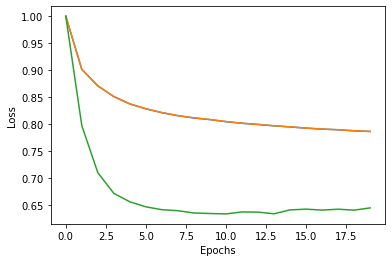

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg/np.max(train_loss_avg))
plt.plot(train_loss1_avg/np.max(train_loss1_avg))
plt.plot(train_loss2_avg/np.max(train_loss2_avg))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Evaluation du score sur le Dataset de TEST

In [12]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss,_,_ = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 18491.295429


# Sauvergarde du réseau entrainé 

In [13]:
# Specify a path
PATH = "model_MNIST.pt"

# Save
torch.save(vae, PATH)

# Chargement du réseau entrainé 

In [7]:
PATH = "model_MNIST.pt"
FashionNet = torch.load(PATH)


# 2 possibilités

- Soit on charge le modèle qu'on vient d'entraîner
- soit on charge le modèle enregistré, en remplaçant "vae" par "FashionNet" dans la suite 

# Reconstruction 

Image originale
VAE reconstruction:


D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


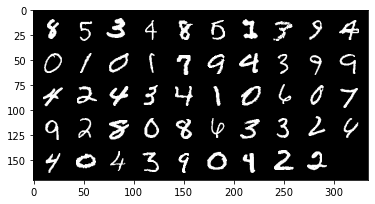

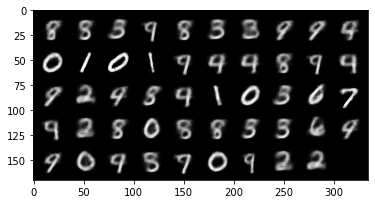

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils
SAVEFIG=True
vae.eval()

# En entrée, l'image à reconstruire et le modèle utilisé pour la reconstruction



def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    fig=plt.figure()
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    return fig

def visualise_output(images, model):

    with torch.no_grad():
        fig=plt.figure()
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        
    return fig

images, labels = iter(test_dataloader).next()

# Affichage de l'image originale
print('Image originale')
fig=show_image(torchvision.utils.make_grid(images[1:50],10,5))
fig.show()
if SAVEFIG:
    plt.savefig('figures/MNISToriginal.svg', format='svg')


# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
fig=visualise_output(images, vae)
fig.show()
if SAVEFIG:
    plt.savefig('figures/MNISTreconstruction.svg', format='svg')


In [14]:
# Interpolation dans l'espace latent

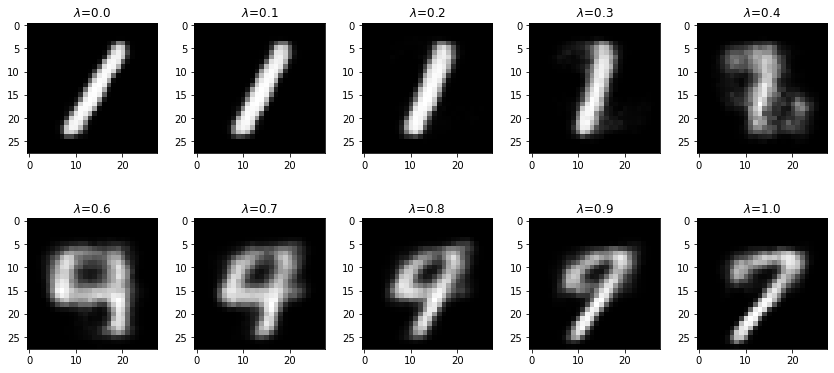

In [24]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # vecteur latent de la première image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # vecteur latent de la deuxième image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation des deux vecteurs latents
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruction de l'image interpolée
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# Sort une partie du dataset test par numéro
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation des lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title(r'$\lambda$='+str(round(l,1)))
#plt.show() 
if SAVEFIG:
    plt.savefig('figures/interpLatentSpaceMNIST.svg', format='svg')

# Utilisation du VAE comme générateur

Un autoencodeur variationnel peut générer de nouveaux chiffres en tirant des vecteurs latents de la distribution précédente. Les chiffres générés ne sont bien sûr pas parfaits

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


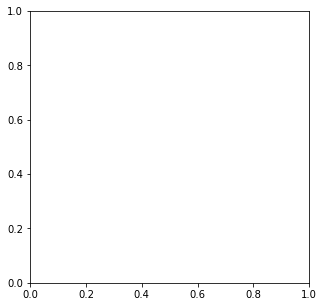

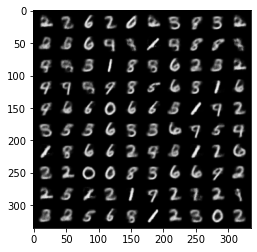

In [25]:
vae.eval()

with torch.no_grad():

    # Sample vecteurs latent from normal distrib
    
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruction des images des vecteurs latents
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    fig=show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    #plt.show()
    fig.show()
if SAVEFIG:
    plt.savefig('figures/generationMNIST.svg', format='svg')

# Espace latent 2D

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


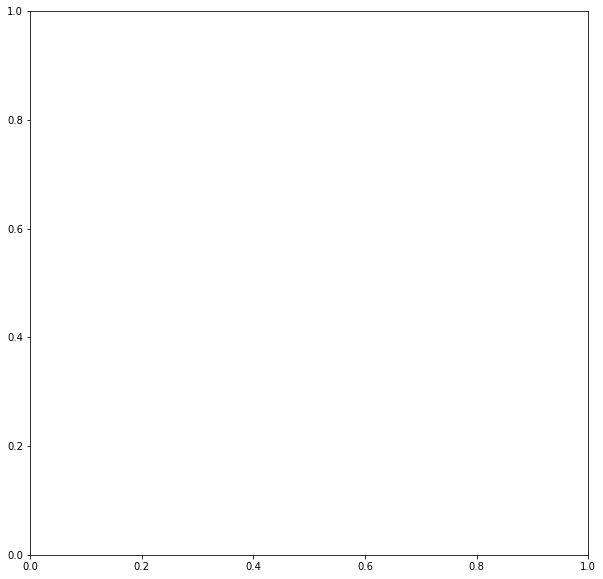

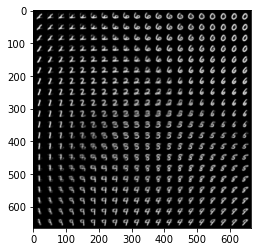

In [28]:
# on charge un réseau entrainé avec un espace latent 2 dimensions
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    fig=show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    fig.show()
    
    if SAVEFIG:
        plt.savefig('figures/latentSpaceMNIST.svg', format='svg')